# 1 Import reduced dimensions data and required libraries 
- Import reduced dimensions data generated from the previous notebook (`03_Feature_Engineering_Dimensionality_Reduction`).
- Import all necessary libraries (please install if you do not have them).

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from kneed import KneeLocator
# import cleaned data
df = pd.read_parquet('data/interim/df_reduced_dim_pd.parquet')
df_original = pd.read_parquet('data/interim/data_outliers_cleared.parquet')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC_1    1600 non-null   float64
 1   PC_2    1600 non-null   float64
 2   PC_3    1600 non-null   float64
 3   PC_4    1600 non-null   float64
 4   PC_5    1600 non-null   float64
 5   PC_6    1600 non-null   float64
 6   PC_7    1600 non-null   float64
 7   PC_8    1600 non-null   float64
 8   PC_9    1600 non-null   float64
dtypes: float64(9)
memory usage: 112.6 KB
None





**From above cell: data transferred correctly with new name for features (pc_0 to pc_8)**

# 2. Determine optimal number of clusters
- Use Elbow method

Optimal number of clusters: 3
WCSS at elbow point: 11800.524424263393


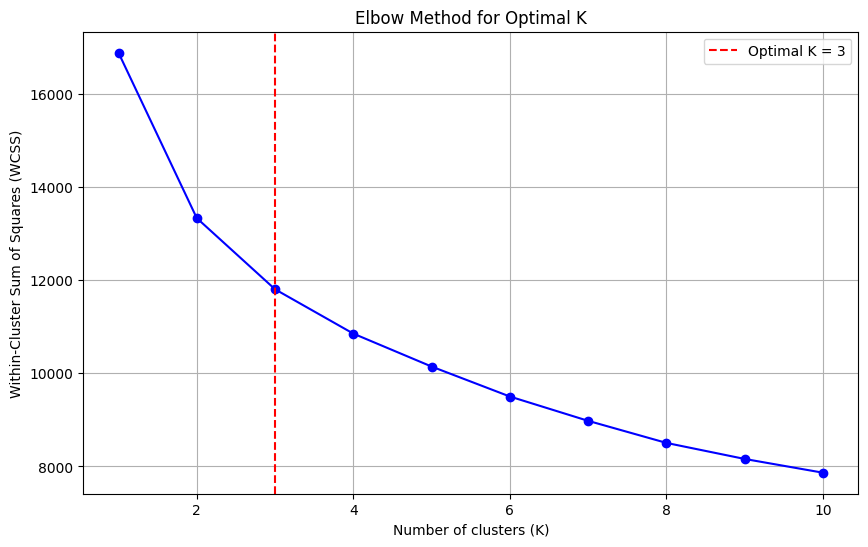

In [80]:
# Generate WCSS values (Within-Cluster Sum of Squares)
K = range(1, 11)  # Test 1 to 10 clusters
wcss = []  # Store the WCSS values

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

# Use KneeLocator to find the optimal number of clusters
kl = KneeLocator(K, wcss, curve="convex", direction="decreasing")

print("Optimal number of clusters:", kl.elbow)
print("WCSS at elbow point:", wcss[kl.elbow - 1])  # -1 because K starts at 1

# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.axvline(x=kl.elbow, color='r', linestyle='--', label=f'Optimal K = {kl.elbow}')
plt.legend()
plt.grid(True)
plt.savefig('plots/Elbow_Optimal_K.png')
plt.show()

**From above cell: number of optimal clusters: 3**

# 3. Apply clustering methods: K-Means, Hierarchical Clustering, GMM.

In [81]:
print('******KMeans clustering **************')
sil_by_k = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(df)
    sil_by_k[k] = silhouette_score(df, km.labels_)

k_sil_best = max(sil_by_k, key=sil_by_k.get)
print("Best number of clusters by silhouette (2..10) =", k_sil_best, "score=", sil_by_k[k_sil_best])

print('******Agglomerative clustering **************')
sil_by_k = {}
for k in range(2, 11):
    Agg = AgglomerativeClustering(n_clusters=k).fit(df)
    sil_by_k[k] = silhouette_score(df, Agg.labels_)

k_sil_best = max(sil_by_k, key=sil_by_k.get)
print("Best number of clusters by silhouette (2..10) =", k_sil_best, "score=", sil_by_k[k_sil_best])

print('******GaussianMixture clustering **************')
sil_by_k = {}
for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, random_state=42).fit(df)
    sil_by_k[k] = silhouette_score(df, gmm.predict(df))

k_sil_best = max(sil_by_k, key=sil_by_k.get)
print("Best number of clusters by silhouette (2..10) =", k_sil_best, "score=", sil_by_k[k_sil_best])


******KMeans clustering **************
Best number of clusters by silhouette (2..10) = 2 score= 0.19538401053708315
******Agglomerative clustering **************
Best number of clusters by silhouette (2..10) = 2 score= 0.15490859063471274
******GaussianMixture clustering **************
Best number of clusters by silhouette (2..10) = 2 score= 0.17981446259092018


**Analysis of clustering method performance:**
- Although there is no significant performance difference between the clustering methods, KMeans shows slightly better performance.
- Number of optimal clusters (from the metric): 2
- Number of optimal clusters (from elbow method): 3

# 4. Visualization of the clusters
- 2D visualization for 2 clusters (with approximate boundaries between them)
- 2D visualization for 3 clusters (with approximate boundaries between them)

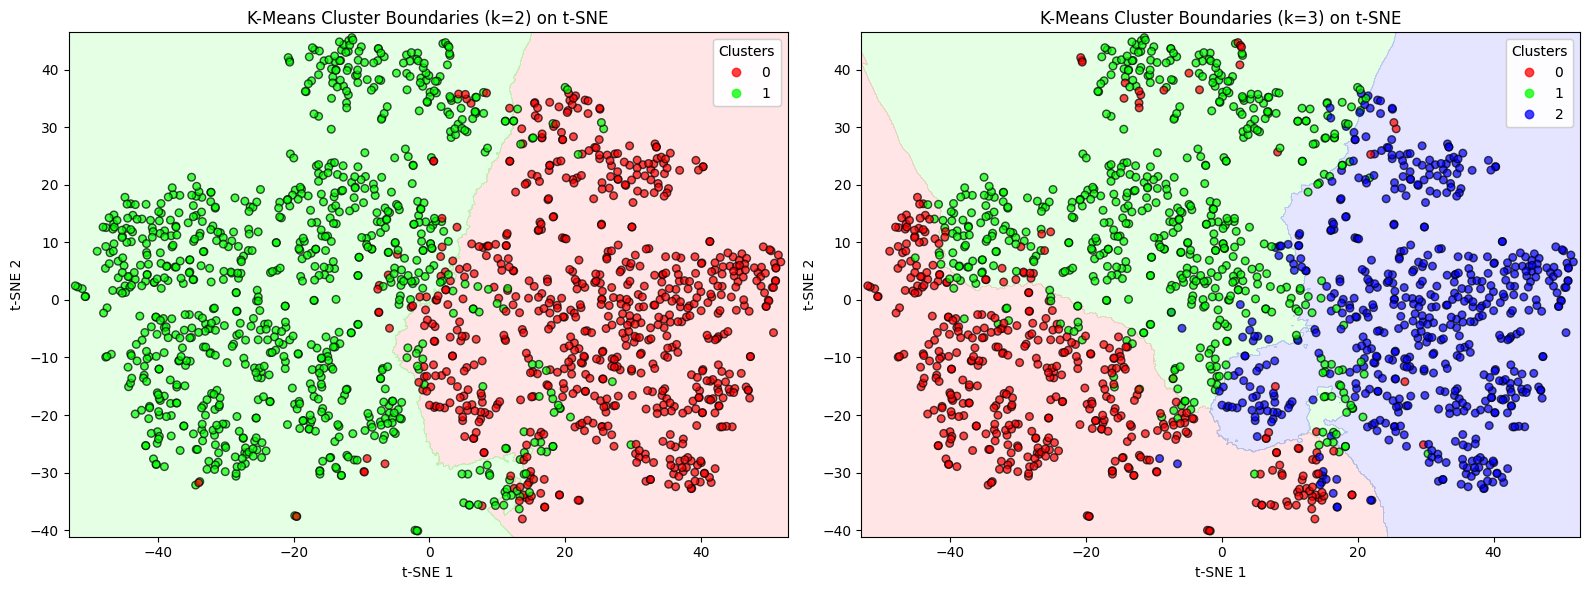

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

# 1. Perform clustering and get labels for k=2 and k=3
kmeans_k2 = KMeans(n_clusters=2, random_state=42, n_init=10).fit(df)
kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init=10).fit(df)

labels_k2 = kmeans_k2.labels_
labels_k3 = kmeans_k3.labels_

# 2. Create the t-SNE transformation (use the same for both)
tsne = TSNE(n_components=2, random_state=42, init='pca')
X_tsne = tsne.fit_transform(df)

# 3. Create a function to plot decision boundaries
def plot_cluster_boundaries(X_2d, labels, k, title, ax):
    
    # Create a color map for the background
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'][:k])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'][:k])
    
    # Train a KNN classifier on the t-SNE coordinates and the labels
    # This learns the boundaries in the 2D visual space.
    clf = KNeighborsClassifier(n_neighbors=50) 
    clf.fit(X_2d, labels)
    
    # Step size of the mesh. Decrease h for smoother boundaries.
    h = .1 
    # Create a mesh grid that covers the range of the t-SNE points
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict the cluster for each point in the mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    
    # Plot the actual data points
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap=cmap_bold, s=30, edgecolor='k', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    
    # Create a legend
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

# 4. Create the figure and plot both cases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plot_cluster_boundaries(X_tsne, labels_k2, k=2, 
                        title='K-Means Cluster Boundaries (k=2) on t-SNE', ax=ax1)
plot_cluster_boundaries(X_tsne, labels_k3, k=3, 
                        title='K-Means Cluster Boundaries (k=3) on t-SNE', ax=ax2)

plt.tight_layout()
plt.savefig('plots/Clusters_visulation_k_2_3.png')
plt.show()

**Results:**
- Splitting datasets into two groups is better than three clusters
- I chose two clusters

# 5. Data split based on the clustering result
- The cleaned dataset is divided into subsets corresponding to each cluster (cluster_0 and cluster_1), enabling further analysis of cluster-specific characteristics if needed

In [83]:
df_original = pd.read_parquet('data/interim/data_outliers_cleared.parquet')

# Add the cluster labels as a new column in original DataFrame
df['cluster'] = labels_k2



# Split the DataFrame into Two Groups
cluster_0_df = df[df['cluster'] == 0] # All rows where cluster is 0
cluster_1_df = df[df['cluster'] == 1] # All rows where cluster is 1

mask1 = df_original.index.isin(cluster_0_df.index)
mask2 = df_original.index.isin(cluster_1_df.index)

# Apply the mask
group1 = df_original[mask1]
group2 = df_original[mask2]

# Display the first few rows of each divided group to confirm
print("*************First group:***************************")
print(group1.head(5))
print("*************Second group:**************************")
print(group2.head(5))

*************First group:***************************
   number_row                         name               album release_date  \
0           0   Concert Intro Music - Live  Licked Live In NYC   2022-06-10   
1           1   Street Fighting Man - Live  Licked Live In NYC   2022-06-10   
2           2           Start Me Up - Live  Licked Live In NYC   2022-06-10   
3           3  If You Can't Rock Me - Live  Licked Live In NYC   2022-06-10   
4           4            Don’t Stop - Live  Licked Live In NYC   2022-06-10   

   track_number                      id                                   uri  \
0             1  2IEkywLJ4ykbhi1yRQvmsT  spotify:track:2IEkywLJ4ykbhi1yRQvmsT   
1             2  6GVgVJBKkGJoRfarYRvGTU  spotify:track:6GVgVJBKkGJoRfarYRvGTU   
2             3  1Lu761pZ0dBTGpzxaQoZNW  spotify:track:1Lu761pZ0dBTGpzxaQoZNW   
3             4  1agTQzOTUnGNggyckEqiDH  spotify:track:1agTQzOTUnGNggyckEqiDH   
4             5  7piGJR8YndQBQWVXv6KtQw  spotify:track:7piGJR8YndQB

# 6. Save splitted the cleaned dataset into two groups.
- The two groups are saved separately

In [84]:
cluster_0_df.to_parquet('data/interim/group_0_df.parquet')
cluster_1_df.to_parquet('data/interim/group_1_df.parquet')